In [1]:
import matplotlib.pyplot as plt
import numpy as np
# from matrixopt.models import *
from math import pi, sqrt


# Přepočty z https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=14204
def calculate_rayleigh_range(mfd, wave_length) -> float:
    return pi / wave_length * (mfd / 2)**2

def calculate_q_param(z, z_r, z_waist=0) -> complex:
    return complex(z - z_waist, z_r)

def calculate_fiber_beam_radius_at_z(z, z_r, mfd) -> float:
    return mfd/2 * sqrt(1 + (z/z_r)**2)

# Gaussovský svazek na výstupu zvlákna

Text(0, 0.5, 'Beam diameter [mm]')

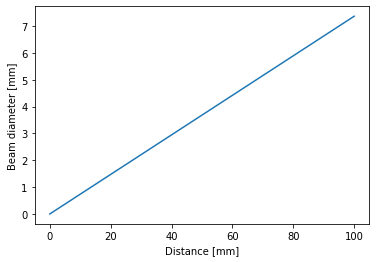

In [35]:
# Toptica OE-000592 je real -> https://www.toptica.com/products/optical-isolators-photonicals/photonicals/optical-fibers
MODAL_FIELD_DIAMETER = 3.5e-6
NA = 0.07
WL = 405e-9


z_r = calculate_rayleigh_range(MODAL_FIELD_DIAMETER, WL)
# q = calculate_q_param()
distance_in_mm = np.linspace(0,100,1000)
beam_radius = [calculate_fiber_beam_radius_at_z(d*10**(-3), z_r, MODAL_FIELD_DIAMETER) for d in distance_in_mm]
beam_radius_in_mm = [br*10**(3) for br in beam_radius]
plt.plot(distance_in_mm, beam_radius_in_mm)
plt.xlabel("Distance [mm]")
plt.ylabel("Beam diameter [mm]")


In [10]:
def get_beam_diameter(q_start: complex, wl, n, z: float) -> float:
    """_summary_

    Args:
        q_start (complex): q param ..
        wl (_type_): wavelength
        n (_type_): refractive index
    """
    q_z = q_start + z
    imag_inverse_q_z = (1/q_z).imag
    return sqrt(-(wl / (n * pi * imag_inverse_q_z)))

def get_waist_location(current_z: float, q: complex) -> float:
    # q = z - z0 + iz_r -> z0 = Real(q) - z
    return current_z - q.real


# Propagace systémem

In [85]:
from matrixopt.matrixopt.matrix_optics import *
# from scipy import optimize

# LAYOUT START
q_in = calculate_q_param(0,z_r)

d1 = 3.6e-2
lens1 = ThinLens(f=3.5e-2)
d2 = 10e-2
lens2 = ThinLens(f=150e-3)
op = OpticalPath(d1, lens1, d2, lens2)

q_out = op.propagate(q_in)
# LAYOUT END




# DATA
w_loc = get_waist_location(q_out, d1 + d2)
zr = q_out.imag
w0 = sqrt((WL * zr) / pi)
divergence = WL/(pi * 1 * w0)

print(f"w_loc: {w_loc*10**2}cm")
print(f"w0: {w0*10**3}mm")
print(f"divergence: {divergence*57.2957}stupnu")




w_loc: 129.28700894494435cm
w0: 0.06111057207962586mm
divergence: 0.12086785945045879stupnu
